<h1 align='center'> Efficient Net Learning and Understanding </h1>

<div>
    <p> This notebook discusses on the learning of efficientnet and working on dataset where words have been written and our final Model will be able to predict which word the provided word is </p>
</div>

In [1]:
import tensorflow as tf
from keras.applications.efficientnet import EfficientNetB0
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

<h3> Understanding Architecture of Efficient Net </h3>

In [2]:
model=EfficientNetB0()
'''The code below of model summary can be uncommented to study the data a little bit more'''
#model.summary()
del model

<h3> Pre Processing Dataset </h3>

In [3]:
def convert_image_to_tensor(path):
    img=Image.open(path)
    img=img.resize((224,224))
    img=np.asarray(img)
    return img

images_list=[]
labels_list=[]
labels_map={}
label_val=0
i='data_1/natural_images'
for folder in os.listdir(i):
    labels_map[label_val]=folder
    for file in os.listdir(i+'/'+folder):
        images_list.append(i+'/'+folder+'/'+file)
        labels_list.append(label_val)
    label_val+=1

labels_map

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

In [4]:
print(len(images_list),len(labels_list))
layers=tf.keras.layers.CategoryEncoding(num_tokens=len(list(set(labels_list))), output_mode="one_hot")
labels_list=np.array(layers(labels_list))
images_list=np.array([convert_image_to_tensor(i) for i in images_list])

6899 6899


In [5]:
X,Xtest,Y,Ytest=train_test_split(images_list,labels_list)

<h3> Custom Sizing the image and creating transfer learning architecture </h3>

In [7]:

input_val=tf.keras.layers.Input(shape=(224,224,3))

model=EfficientNetB0(include_top=False,input_tensor=input_val,weights='imagenet')

for i in range(int(len(model.layers) * 0.75)):
    model.layers[i].trainable = False

#model.trainable = False


x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#x=tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(len(labels_map), activation="softmax", name="pred")(x)

model=tf.keras.Model(inputs=input_val,outputs=output)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

'''This code below can be used to check out the new model summary to see how much changed this model is from previous one.'''
#model.summary()

'This code below can be used to check out the new model summary to see how much changed this model is from previous one.'

In [9]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',mode='auto',restore_best_weights=True )
hist=model.fit(X,Y,validation_data=(Xtest,Ytest),epochs=10,callbacks=[callback],batch_size=128)

Epoch 1/10
41/41 [==============================] - 123s 3s/step - loss: 0.1047 - accuracy: 0.9685 - val_loss: 0.0111 - val_accuracy: 0.9977
Epoch 2/10
41/41 [==============================] - 123s 3s/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0219 - val_accuracy: 0.9925
Epoch 3/10
41/41 [==============================] - 128s 3s/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0077 - val_accuracy: 0.9977
Epoch 4/10
41/41 [==============================] - 125s 3s/step - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.0064 - val_accuracy: 0.9983
Epoch 5/10
41/41 [==============================] - 129s 3s/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0040 - val_accuracy: 0.9983
Epoch 6/10
41/41 [==============================] - 126s 3s/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0031 - val_accuracy: 0.9983
Epoch 7/10
41/41 [==============================] - 136s 3s/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0084 - val_accuracy: 0.9977
Epoch 8/10
41

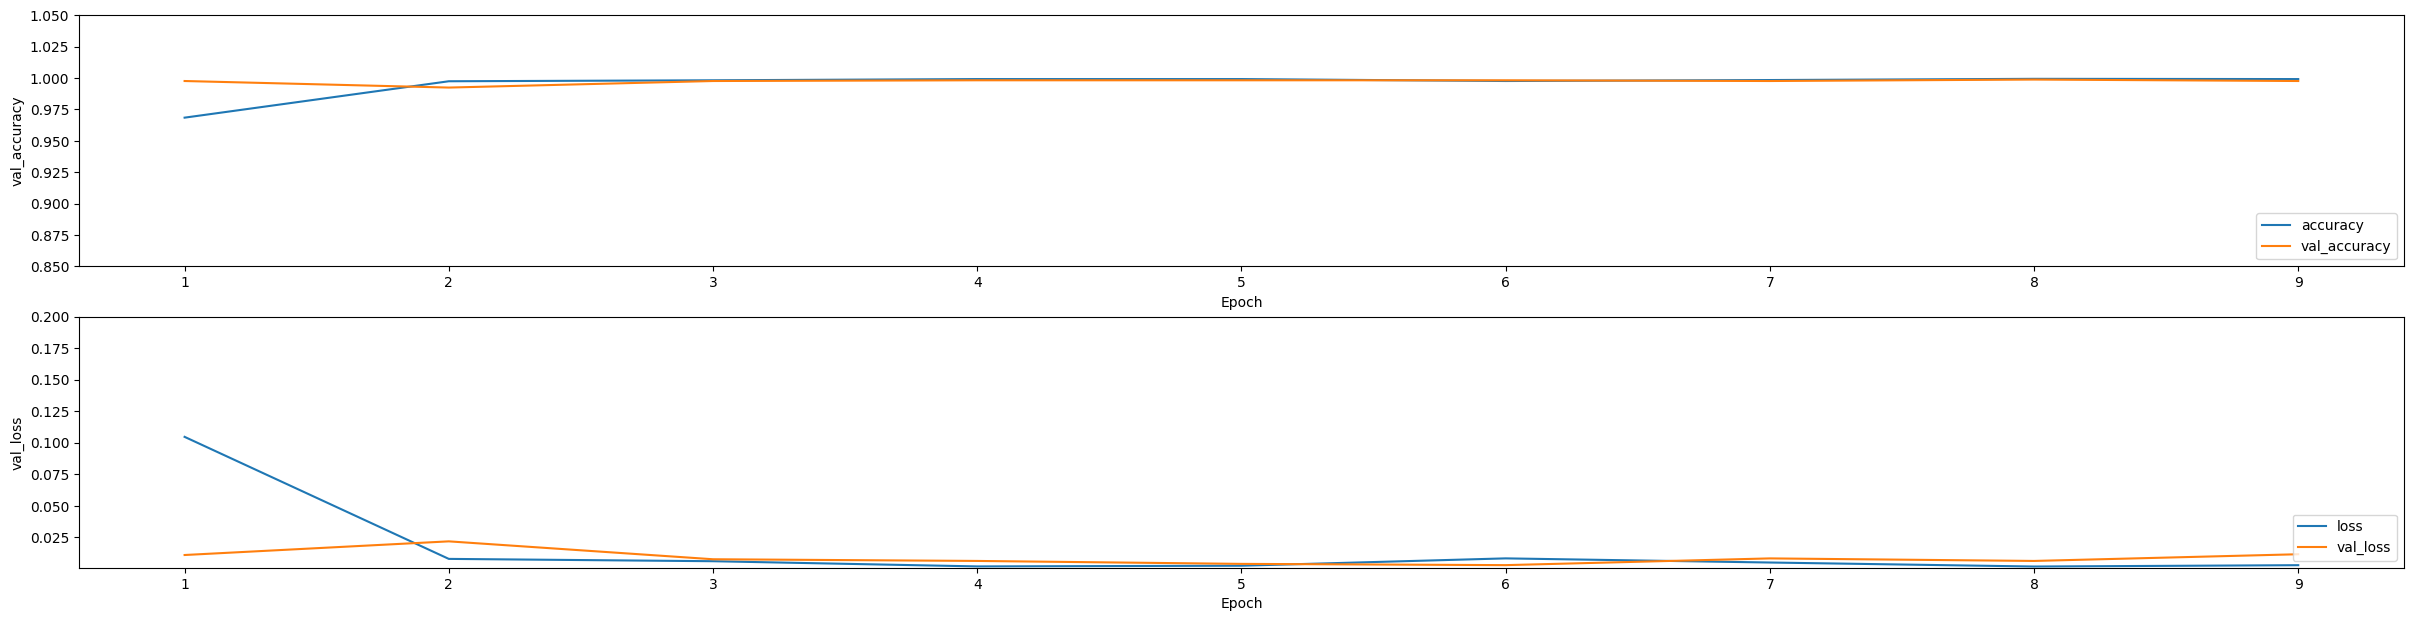

In [10]:
def plot_metrics_for_training(history):
    
    plt.figure(figsize=(30, 15))
    plt.subplot(411)
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label = 'val_accuracy')
    plt.xticks(np.arange(len(history['accuracy'])), np.arange(1, len(history['accuracy'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('val_accuracy')
    plt.ylim([0.85, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(412)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.xticks(np.arange(len(history['loss'])), np.arange(1, len(history['loss'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('val_loss')
    plt.ylim([0.001, 0.20])
    plt.legend(loc='lower right')

plot_metrics_for_training(hist.history)

<h3> Inference Testing </h3>

1/1 [==============================] - 1s 837ms/step
airplane


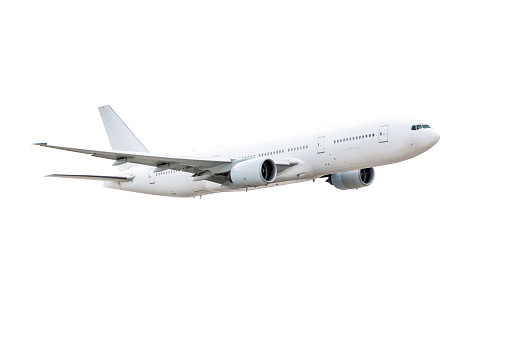

In [11]:
def take_inference_and_predict(model):
    inference_=input('Enter path of the file to test: ')
    img=Image.open(inference_)
    inference_=convert_image_to_tensor(inference_)
    inference_=inference_.reshape(1,inference_.shape[0],inference_.shape[1],inference_.shape[2])
    print(labels_map[np.argmax(model.predict(inference_))])
    return img

img=take_inference_and_predict(model)
img


<p> This cell might have some problem due to tensorflow version issue we need to use tf 2.9.0 </p>

In [ ]:
model.save('Efficient_net_custom.h5')

1/1 [==============================] - 1s 883ms/step
motorbike


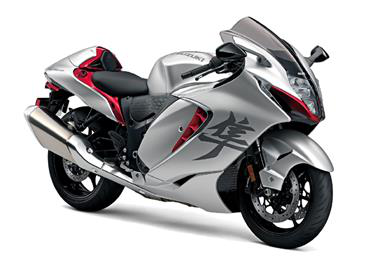

In [12]:
loaded_model=tf.keras.models.load_model('Efficient_net_custom.h5')
img=take_inference_and_predict(loaded_model)
img